In [1]:
import os
import boto3
from dotenv import load_dotenv
import io 
import pandas as pd

load_dotenv()

YC_ACCESS_KEY_ID = os.getenv("YC_ACCESS_KEY_ID")
YC_SECRET_ACCESS_KEY = os.getenv("YC_SECRET_ACCESS_KEY")
YC_ENDPOINT_URL = os.getenv("YC_ENDPOINT_URL")
YC_BUCKET_NAME = os.getenv("YC_BUCKET_NAME")

In [2]:
session = boto3.session.Session()
s3_client = session.client(
    service_name='s3',  
    endpoint_url=YC_ENDPOINT_URL,
    aws_access_key_id=YC_ACCESS_KEY_ID,
    aws_secret_access_key=YC_SECRET_ACCESS_KEY
)

In [3]:
import gzip


data_location = "final_train_datasets/"
file_names = ["0m_lags.csv.gzip", "3m_lags.csv.gzip", "6m_lags.csv.gzip", "12m_lags.csv.gzip"]


data_storage = dict()
for file_name in file_names:
    response = s3_client.get_object(Bucket=YC_BUCKET_NAME, Key=f'{data_location}{file_name}')
    data_storage[file_name[: len(file_name) - 9]] = pd.read_csv(io.BytesIO(response['Body'].read()), compression='gzip')




Feature extraction step has been made before. Added some lags features.

In [4]:
train = (data_storage['12m_lags' ])

In [12]:
import sys
%load_ext autoreload
%autoreload 2

sys.path.append('../src')
from validation_schema import TimeSeriesRollingValidator


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Generating a sliding window for model evaluation.

In [13]:
validator = TimeSeriesRollingValidator(train, 'date_block_num', train_window=3, test_window=1)
splits = validator.split_data_rolling()

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error

In [15]:
def model_learning_function(train, val, test):
    X_train = train.drop(columns=['item_cnt_month'])
    y_train = train['item_cnt_month']
    
    model = LinearRegression()
    model.fit(X_train, y_train)

    return model

In [20]:
metrics = {
    "RMSE": root_mean_squared_error, 
    "MAPE": mean_absolute_percentage_error,
    "R2": r2_score
}


validation_data = validator.validate(model_learning_function, metrics, splits, "item_cnt_month")
validation_data.head(5)

,model,train_months,val_months,test_months,dummy_RMSE_test,dummy_MAPE_test,dummy_R2_test,dummy_RMSE_val,dummy_MAPE_val,dummy_R2_val,...,dummy_R2_train,model_RMSE_test,model_MAPE_test,model_R2_test,model_RMSE_val,model_MAPE_val,model_R2_val,model_RMSE_train,model_MAPE_train,model_R2_train
0,LinearRegression,185610,54204,52931,2.667678,0.636638,-3.608497e+31,2.618104,0.642384,-3.475629e+31,...,-4.580558e+31,2.425291,0.762968,-1.253309,2.328119,0.552281,-0.498063,2.745079,0.617508,-4.030014
1,LinearRegression,177160,52931,55737,2.866588,0.664698,-4.166679e+31,2.665277,0.635648,-3.602004e+31,...,-4.402006e+31,2.530384,0.749315,-3.137178,2.370328,0.550727,-2.035667,2.574631,0.564017,-2.229270
2,LinearRegression,170629,55737,57565,2.887512,0.626836,-1.878991e+31,2.865896,0.664690,-4.164670e+31,...,-1.885603e+31,2.357787,0.814183,-2.091666,2.515064,0.705979,-3.087966,2.553388,0.557175,-2.529408
3,LinearRegression,162872,57565,57549,2.979947,0.674784,-1.125685e+31,2.885686,0.636555,-1.876615e+31,...,-9.360455e+30,2.402155,0.561788,-1.753258,2.296425,0.474909,-1.772501,2.343887,0.529779,-1.906324
4,LinearRegression,166233,57549,50996,3.282367,0.742012,0.000000e+00,2.980145,0.676114,-2.001482e+31,...,-4.002273e+31,2.791112,0.773375,-1.183628,2.371432,0.589161,-1.023628,2.339959,0.519856,-1.264733


I've used a **rolling-window forecast** approach to evaluate my model. This is the gold standard for time series, as it prevents data leakage and provides a realistic measure of future performance. I used the last month for validation and the preceding months for training, which accurately simulates a real-world forecasting scenario.

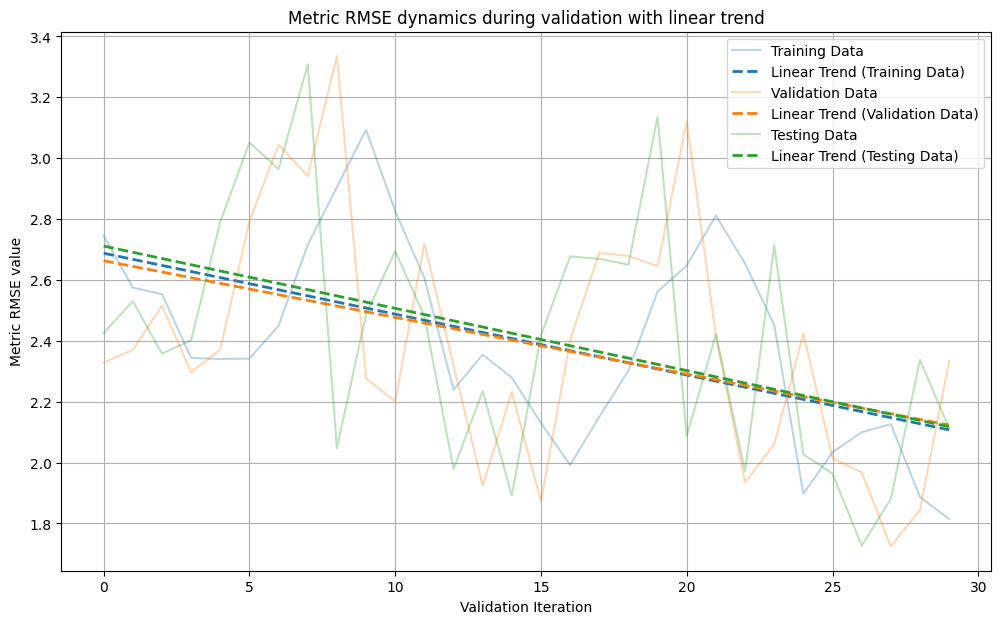

In [19]:
validator.visualize_validation_results_with_linear_trend(validation_data)

A decreasing linear trend in the metrics (like RMSE or MAPE) for the validation or test set, while the training set's trend remains high or flat, is a strong indicator of **data drift**. 

Based on the graph, there is no evidence of **data leakage**. The linear trend lines for the training, validation, and testing data sets all show a consistent, downward slope. This indicates that as the model progresses through validation iterations, its performance (measured by RMSE) is improving across all data sets, which is the expected behavior for a well-performing model. The fact that the validation and testing data also have a consistent trend and don't show a sudden, unexplainable drop suggests the model is generalizing well and is not "peeking" at future data.